# GOATpy Tutorial

This notebook is a tutorial of how to use GOATpy for analysing Glycomics data and aligning the data with a H&E image. First make sure you have setup a conda evironement containing all the packages required for running GOATpy. For instructions on how to do this please visit the README.md file on https://github.com/agc888/goatpy.

Once this is done you can install the package with:

pip install git+https://github.com/agc888/goatpy.git

In [1]:
import goatpy as gp
import spatialdata_plot
import matplotlib.pyplot as plt
import scanpy as sc
import napari
from napari_spatialdata import Interactive

/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
path = "/Users/andrewcauser/Documents/Griffith/AD_resolution_change_check_10um_actual_10012020_2.imzML"
he_path = "/Users/andrewcauser/Documents/Griffith/res_check_0000.tif"

maldi_sd = gp.io.glyco_spatialdata(imzml_path=path)
he_sd = gp.he_spatialdata(he_path)

/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `data

In [3]:
maldi_sd

SpatialData object
├── Points
│     └── 'maldi_pixels': DataFrame with shape: (<Delayed>, 112) (2D points)
└── Tables
      └── 'maldi_adata': AnnData (16455, 108)
with coordinate systems:
    ▸ 'global', with elements:
        maldi_pixels (Points)

In [4]:
he_sd

SpatialData object
├── Images
│     └── 'he_image': DataArray[cyx] (3, 19160, 23633)
└── Points
      └── 'pixels': DataFrame with shape: (<Delayed>, 2) (2D points)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), pixels (Points)

Before aligning the MALDI data to the H&E image, we need to add a pseudo-image layer to the MALDI SpatialData object. This is because the landmark alignment function requires both SpatialData objects to have image layers. To generate a pseudo-image we can use two common datatypes, either TIC intensity or clustering results. TIC is automatically calculated when loading the data using `glyco_spatialdata`. 

GOATpy has GraphPCA imbuilt which uses both spaital data and also glycan insnsity values to indifity similar clusters of pixels. Lets run that below

In [5]:
maldi_sd = gp.graphpca_spatialdata(maldi_sd, tables= "maldi_adata",
    library_id= 'spatial',
    n_components = 50, 
    n_neighbors = 15,
    alpha = 0.5)

maldi_sd = gp.get_kmean_clusters(maldi_sd, tables= "maldi_adata",n_clusters = 8) 

Lets look at the results of the clustering and also our TIC values: 

/var/folders/f1/3f7gj1393nb0phh8vzn910nm0000gn/T/ipykernel_24084/942406809.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(maldi_sd.tables["maldi_adata"], img_key="hires",
/var/folders/f1/3f7gj1393nb0phh8vzn910nm0000gn/T/ipykernel_24084/942406809.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(maldi_sd.tables["maldi_adata"], img_key="hires",


[<Axes: title={'center': 'TIC'}, xlabel='spatial1', ylabel='spatial2'>]

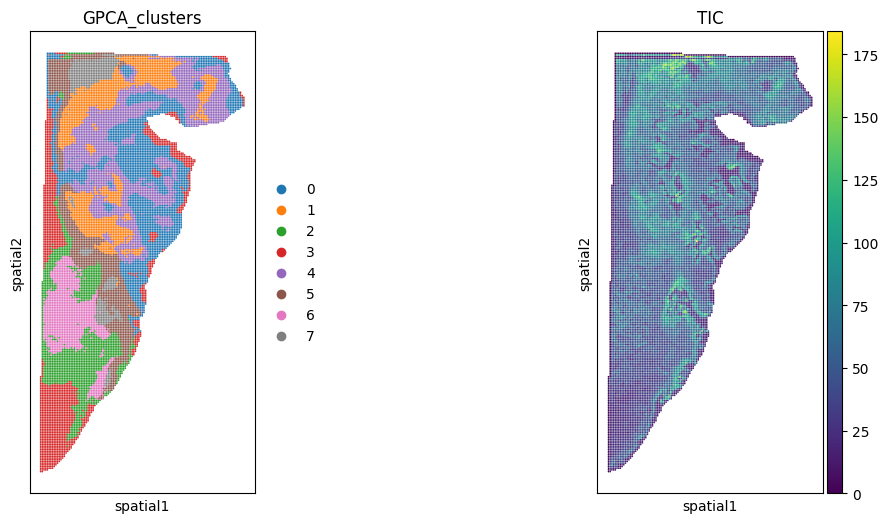

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.spatial(maldi_sd.tables["maldi_adata"], img_key="hires", 
              color=["GPCA_clusters"], size=0.5, spot_size=2,
              alpha_img=0, ax=axs[0], show=False)


sc.pl.spatial(maldi_sd.tables["maldi_adata"], img_key="hires", 
              color=["TIC"], size=0.5, spot_size=2,
              alpha_img=0, ax=axs[1], show=False)


We need a pseudo-image from our maldi data to use to identify landmarks for image alignment, lets use the clustering results:

In [7]:
#maldi_sd = gp.Add_Pseudo_Image(maldi_sd, "TIC", tables = "maldi_adata", library_id = "Spatial", is_continous=True, cmap = "viridis")
maldi_sd = gp.Add_Pseudo_Image(maldi_sd, "GPCA_clusters", tables = "maldi_adata", library_id = "Spatial", cmap = "Paired")

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/spatialdata/_core/_elements.py:128: UserWarning: Key `maldi_adata` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Lets look at the pseudo-image below:


/var/folders/f1/3f7gj1393nb0phh8vzn910nm0000gn/T/ipykernel_24084/3163554094.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(maldi_sd.tables["maldi_adata"], img_key="hires",


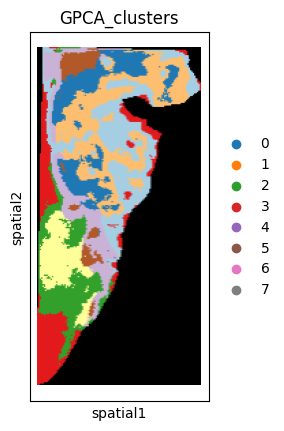

In [8]:
sc.pl.spatial(maldi_sd.tables["maldi_adata"], img_key="hires", 
              color=["GPCA_clusters"], size=0.5, spot_size=0,
              alpha_img=1)

We now must pick landmark points to use for aligning our two spatial data objects. We can use the `lanch_landmark_gui` function which is a specific function built on napari to select points between images. There are two options whereby `split_view` can be either True or false. If `True` then a seperate window will be created for the H&E and MALDI image (good for use with a monitor).

Alternatively, you can also use the normal napari method described [here](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/alignment_using_landmarks.html#adding-landmark-annotations).

In [ ]:
viewer, maldi_v, he_v, widget = gp.launch_landmark_gui(maldi_sd, he_sd, split_view=True)
#viewer, widget = gp.launch_landmark_gui(maldi_sd, he_sd, split_view=False)

/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (19160, 23633, 3) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


Traceback (most recent call last):
  File "/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/vispy/app/backends/_qt.py", line 496, in mousePressEvent
    vispy_event = self._vispy_mouse_press(
  File "/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/vispy/app/base.py", line 184, in _vispy_mouse_press
    ev = self._vispy_canvas.events.mouse_press(**kwargs)
  File "/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/napari/_vispy/canvas.py", line 597, in

INFO: Saved 4 landmark pairs to SpatialData objects


Now lets align the data using the function below:

In [10]:
aligned = gp.align_image_using_landmarks(maldi_sd, he_sd)

In [11]:
aligned

SpatialData object
├── Images
│     ├── 'he_image': DataArray[cyx] (3, 19160, 23633)
│     └── 'optical_image': DataTree[cyx] (3, 248, 120), (3, 124, 60), (3, 62, 30), (3, 31, 15)
├── Points
│     ├── 'maldi_landmarks': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'maldi_pixels': DataFrame with shape: (<Delayed>, 112) (2D points)
└── Tables
      └── 'maldi_adata': AnnData (16455, 108)
with coordinate systems:
    ▸ 'aligned', with elements:
        he_image (Images), optical_image (Images)
    ▸ 'global', with elements:
        he_image (Images), optical_image (Images), maldi_landmarks (Points), maldi_pixels (Points)

We can check the alignment in a normal napari viewer below:

In [ ]:
interactive = Interactive(aligned)
viewer = interactive.run()

2025-12-05 00:38:48.106 | WARNING  | napari_spatialdata._viewer:__init__:57 - Due to Shift-L being used as shortcut in napari, it is being deprecated and might not link a new layer to an existing SpatialData object in the viewer. Please use ⌘-L on MacOS or else Ctrl-L.


/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/napari/_vispy/layers/scalar_field.py:197: UserWarning: data shape (19160, 23633) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
2025-12-05 00:38:56.279 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
2025-12-05 00:38:56.280 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.
/Users/andrewcauser/anaconda3/envs/maldi/lib/pyth

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


/Users/andrewcauser/anaconda3/envs/maldi/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:184: UserWarning: The table is annotating 'maldi_pixels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


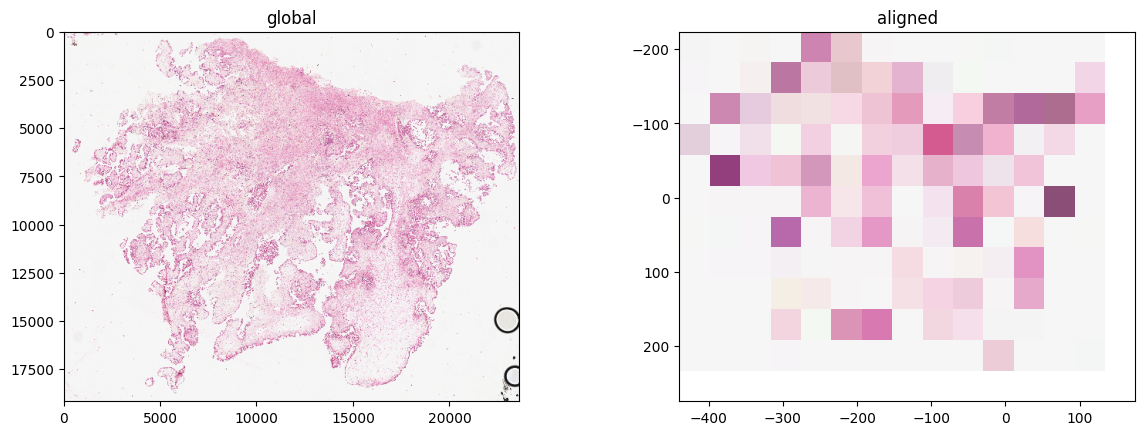

In [12]:
aligned.pl.render_images("he_image").pl.show()